## This notebook shortly explains how to use Quandary through the python interface.
Latest update: 11/14/2023, Stefanie Guenther (guenther5@llnl.gov)

Content:
 1. How to generate control pulses for a **unitary gate**
 2. How to evaluate pulses on a specific sample rate
 3. How to get the propagator and/or the fidelity for given control parameters from Quandary?
 4. How to to generate pulses that realise a **state to state** transfer
 5. How to use the open-system solver to model decay and dephasing
 6. *Coming soon*: FAQ ("What if...")

The full Quandary user-guide can be found here:
https://github.com/LLNL/quandary/blob/pythoninterface/doc/user_guide/main.pdf \
The pythoninterface functions as used here are defined in './quandary.py'. That file might be a valuable resource to check for default settings and available options that are not described in this notebook. 

In [ ]:
# Load Quandary python interface functions
from quandary import *

# Set the location of the Quandary c++ executable
quandary_exec = "/path/to/quandary/executable"  # Location of your Quandary executable

### 1. How to use Quandary to generate pulses that realize a **unitary gate**

Executing ' mpirun -np 3 /Users/guenther5/Numerics/quandary/main ./config.cfg --quiet ' ...
    Objective             Tikhonov                Penalty-Leakage        Penalty-StateVar       Penalty-TotalEnergy 
0  8.90827017820553e-01 + 9.29555280047611e-09 + 2.25298114984752e-07 + 2.65005198380265e-09 + 3.90142770793062e-07  Fidelity = 1.09172982179447e-01  ||Grad|| = 1.07398755654442e-01
1  8.23593403906375e-01 + 1.29561568615448e-07 + 6.69047877074672e-06 + 3.28402044392494e-07 + 1.02574299103145e-05  Fidelity = 1.76406596093625e-01  ||Grad|| = 1.85029862207919e-01
2  7.63434350878314e-01 + 7.51771569351034e-08 + 3.66886396899037e-06 + 3.51660104513399e-07 + 5.79029761350617e-06  Fidelity = 2.36565649121686e-01  ||Grad|| = 8.12317297898518e-02
3  4.94533182179734e-01 + 1.92923441166080e-07 + 5.61793963573586e-06 + 1.48266511013356e-06 + 1.53767523827749e-05  Fidelity = 5.05466817820266e-01  ||Grad|| = 1.43622287206724e-01
4  1.05179999801975e-01 + 1.94821914222611e-07 + 5.883096678595

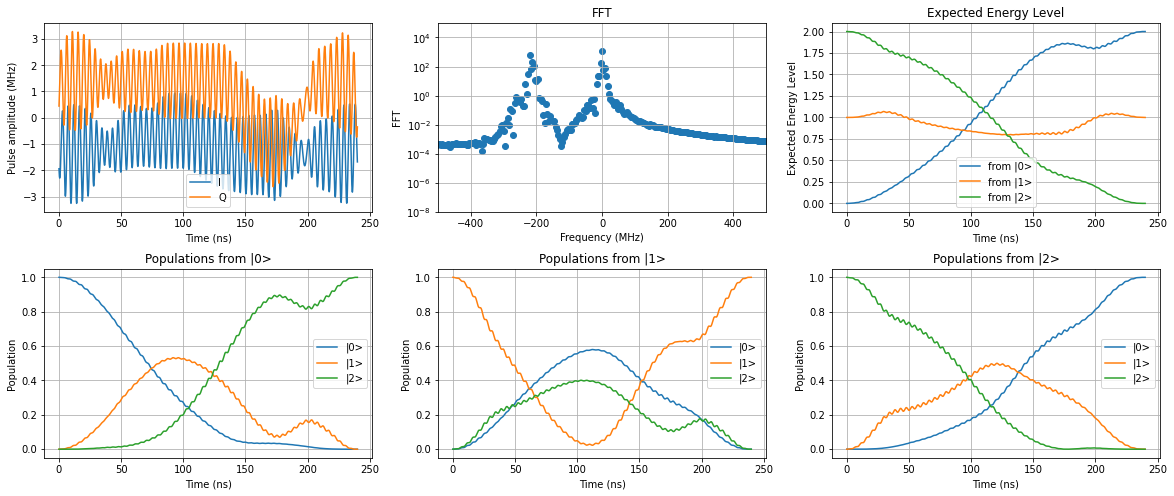

In [6]:
#
# THE SHORT STORY...
# 
# Example usage of Quandary to optimize for a SWAP 02 gate. 
# This example considers a three-level qubit with one extra guard level, which is the default.

# Define the number of qubits and states per qubit. Here: One qudit modelled with 3 essential levels and one extra guard level
Ne = [3]
Ng = [1]

# Required: Define the target and pulse duration
unitary = [[0,0,1],[0,1,0],[1,0,0]]   # Target unitary gate, here SWAP02
pulse_length = 240.0                  # Pulse duration, unit ns

# Optionally: Set bounds on the control pulse amplitudes in rotational frame [MHz]
maxctrl_MHz = 4.0  

# Pass all options to the Quandary configuration. 
quandary_config = QuandaryConfig(targetgate=unitary, T=pulse_length, maxctrl_MHz=maxctrl_MHz)

# Execute quandary. Runs in the background on <prod(Ne)> cores. 
t, p, q, infidelity, expectedEnergy, population = quandary_run(quandary_config, quandary_exec=quandary_exec)
print(f"\nOptimized Fidelity = {1.0 - infidelity}")

# Quandary returns 
#   * t              : a list of time-points where the optimized control pulses are stored (ns) 
#   * p, q           : lists of the control pulses p(t) and q(t), unit MHz, evaluated at each time point in the list t
#   * infidelity     : 1-fidelity of the realized unitary compared to the target gate
#   * expectedEnergy : a list of the extected energy level of the qubit evaluated at each time point
#   * population     : lists of the level occupations (population) evaluated at each time point, one list for each initial basis state 

# In addition, the following other results can be accessed after quandary_run(..) has been called:
#   * quandary_config.popt  (list)   : The optimized B-spline parameters that define the optimized pulses p and q
#   * quandary_contig.uT    (matrix) : The solution operator / process matrix / propagator, see below

# Plot the results. Other plotting functions are available, see ./quandary.py
plot_results_1osc(quandary_config, p[0], q[0], expectedEnergy[0], population[0])

In [7]:
#
# THE LONG STORY...
#
# Quandary uses B-spline basis functions to parameterize control pulses p and q. It then solves Schroedinger's equation (or alternatively Lindblad's master equation, see 6.) for each initial state to compute the solution operator and compares it to the target unitary gate. Quandary then applies a gradient-based optimization method to optimize the B-spline coefficients that yield optimized pulses. 

# Useful optional arguments for QuandaryConfig(...) that determine how quandary_run(config) operates:
#   * pcof0               (List)  : Initial guess for the optimization variables in terms of the Bspline coefficients. 
#   * pcof0_filename      (String): Load the initial guess for the Bspline coefficients from this file (Format: Text file containing the list of coefficients in one column. 
#   * initctrl_MHz        (Float) : Amplitude of the initial pulse guess (if randomized, the initial pulse amplitude will be smaller than this number). Default: 1 MHz
#   * randomize_init_ctrl (Bool)  : Switch whether initial control pulse should be a randomized pulse, or a constant pulse. Default: True (randomized). Only active if pcof0 is NOT given.
#   * rand_seed           (int)   : Fixed seed for the random number generator (Default: system time, non reproducable)
#   * control_enforce_BC  (Bool)  : Switch whether the control pulses should start and end at zero (p(t)=0 at t=0 and t=T). Default 'False'. 
#   * nsplines            (Int)   : Number of Bspline basis functions used to parameterize the pulse. Default = T/10.0 + 2, gives a 10ns spacing between the bspline basis functions. 
#   * tol_infidelity      (Float) : Targeted accuraty of the pulses in terms of the fidelity. Default '1e-4' gives a 99.99% fidelity gate). 
#   * maxiter             (Int)   : Maximum number of optimization iterations (default 100).
#   * Pmin                (Int)   : Use this many time-points to discretize one period of the solution. The higher the number, the more accurate the solution will be, and the longer the computation will take. (Default: 150)
#   * verbose             (Bool)  : Flag to print more output (default: false). Usefull for debugging.


# Note:
# By default, Quandary operates on one qudit, modelling the first THREE energy levels and one additional extra guard levels. The solution operator therefore has dimension 4x3: One column for each initial basis states (0,1,2) and each column contains 3+1=4 levels.
# To remove guard-levels, or change the number of considered energy levels, you can change the config options Ne and Ng, e.g. with
#   * Ne = [2] 
#   * Ng = [0]
# for a single quBit with two energy levels and no guard level (-> 2x2 solution matrix). Make sure to pass those to the QuandaryConfig(Ne=Ne, Ng=Ng,...)


# Optional arguments for quandary_run(...):
#   * runtype     (String)  : "optimization" (default), or "simulation". Choosing "simulation" will only forward propagate the initial control parameters as specified through the config 
#   * datadir     (String)  : Output directory where Quandary is executed
#   * ncores.     (Int)     : Number of compute cores (default: <number of essential levels>, here 3 by default)

### 2. How to evaluate control pulses on a specific sample rate

In [8]:
# Quandary_run(..) returns control pulses p and q (unit MHz) that are evaluated at each time point in t 
# In oder to evaluate p and q on a different time grid (i.e. to downsample or upsample the pulse), use the following:

# Set the number of desired point per ns where controls are to be evaluated
samplerate = 64

# Define the control parameters that define the pulses. Here, we use the previously optimized ones:
pcof = quandary_config.popt  

# Evaluate the control pulses with the given samplerate
t_ds, p_ds, q_ds = evalControls(quandary_config, pcof=pcof, points_per_ns=samplerate, quandary_exec=quandary_exec)

# Note: You can ignore warning messages such as "Can't read from ...", if they appear here.

### 3. How to get the propagator and/or fidelity for given control parameters from Quandary

In [9]:
# If only the propagator and/or fidelity of given pulses are of interest, but no optimization is desired, you do either of the following.

# (a) If you already ran quandary_run(..) beforehand and just want to get the propagator from that run, you can access it directly: 
propagator_T = quandary_config.uT
# and grab the fidelity from the return of quandary_run(..)

# (b) Otherwise, if you did not call quandary_run(..) yet or if you want to get the propagator and/or infidelity for different control parameters, we need to simulate the dynamics first
quandary_config.pcof0 = quandary_config.popt   # Pass control parameters to quandary_config.pcof0. Here, for demonstration purpuse I use the previously optimized pulse parameters
t, p, q, infidelity, expectedEnergy, population = quandary_run(quandary_config, runtype="simulation", quandary_exec=quandary_exec) # Execute quandary in "simulation" mode to propagate all basis states forward 
propagator_T = quandary_config.uT   # Now get the propagator

# Note that in the example here, quandary_config was configured above with Ne=[3] energy states and Ng=[1] guard level (default). Therefore the propagator is a 4x3 matrix (one column for each of the 3 initial states, each column with 3+1 levels)
# Hopefully, the guard levels are not populated such that you can ignore the last row and extract the 3x3 propagator from
propagator_3x3 = propagator_T[:-1,:] 

print("Propagator = ", propagator_3x3)
print(f"Pulse Fidelity = {1.0 - infidelity}")

# You can also compute the fidelity from the propagator and unitary gate directly, e.g. with
fid = np.abs(np.trace(propagator_3x3.conj().T @ unitary))**2/np.prod(quandary_config.Ne)**2     # ('@' for numpy matrix mult)
print('Pulse Fidelity = ', fid)   

Executing ' mpirun -np 3 /Users/guenther5/Numerics/quandary/main ./config.cfg --quiet ' ...
Objective = 8.91105081057830e-05 + 2.44671796883730e-07 + 9.13546546929548e-06 + 1.62424308433384e-06 + 1.89524637697452e-05
Fidelity = 9.99910889491894e-01
Propagator =  [[ 1.09319544e-03+1.59553125e-03j -1.57082794e-03-2.92864677e-04j
  -8.55068618e-01+5.18400394e-01j]
 [-9.88847532e-05-9.38275681e-04j -8.54663787e-01+5.19178539e-01j
   4.64140443e-04-1.52724876e-03j]
 [-8.56976046e-01+5.15226828e-01j -7.84008506e-04-5.20676344e-04j
   8.82255062e-04+1.82835542e-03j]]
Pulse Fidelity = 0.999910889491894
Pulse Fidelity =  0.9999108895008183


### 4. How to use Quandary to generate pulses that realize a **state-to-state transfer**

target state =  [0.7071067811865475, 0.7071067811865475]
Executing ' /Users/guenther5/Numerics/quandary/main ./config.cfg --quiet ' ...
    Objective             Tikhonov                Penalty-Leakage        Penalty-StateVar       Penalty-TotalEnergy 
0  4.05076669034693e-01 + 7.54074156576359e-09 + 0.00000000000000e+00 + 3.61050542304270e-11 + 6.46424633519504e-07  Fidelity = 5.94923330965307e-01  ||Grad|| = 3.01084049153122e+01
1  1.89996107692781e-02 + 5.20969899502535e-08 + 0.00000000000000e+00 + 1.86602042545884e-09 + 9.18958618166389e-06  Fidelity = 9.81000389230722e-01  ||Grad|| = 8.32913396789645e+00
2  1.79581529914041e-03 + 3.64054067229230e-08 + 0.00000000000000e+00 + 1.29028887146150e-09 + 6.18458102602299e-06  Fidelity = 9.98204184700860e-01  ||Grad|| = 2.55449913916587e+00
3  3.96821632351330e-05 + 3.97197782048083e-08 + 0.00000000000000e+00 + 1.41795579081022e-09 + 6.82095315438526e-06  Fidelity = 9.99960317836765e-01  ||Grad|| = 2.68619008830800e-01
Optimization finish

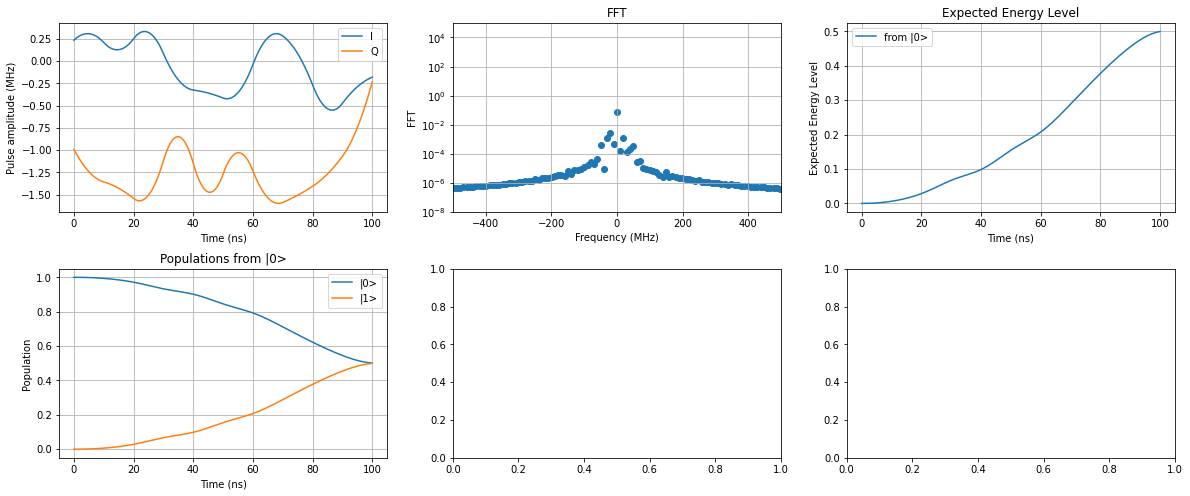

In [10]:
# 
# THE SHORT STORY
# 
# Example how to use Quandary to optimize a state-to-state transfer 

# Optionally: Define the number of essential state and guard levels. This example considers a 2-level qubit with no extra guard level. Default would be 3-level and one guard level, so we change it here
Ne = [2]    # Number of essential states (optional, but adapt the target state dimension accordingly, default Ne=[3])
Ng = [0]    # Number of guard levels (optional, default Ng=[1])

# Define the target state (in the essential level dimensions)
targetstate =  [1.0/np.sqrt(2), 1.0/np.sqrt(2)]   
print("target state = ", targetstate)

# Define the initial state at time t=0. Could here be the 0 or 1 state for the 2-level qubit. 
initialcondition = "pure, 0"

# Pulse length
T = 100.0

# Optionally: Define desired accuraty of the pulse in terms of the infidelity. 
tol_infidelity = 1e-5

# Pass all options to the Quandary configuration
myconfig = QuandaryConfig(Ne=Ne, Ng=Ng, T=T, targetstate=targetstate, initialcondition=initialcondition, tol_infidelity=tol_infidelity)

# Execute quandary. Runs in the background on one core. 
t, pt, qt, infidelity, expectedEnergy, population = quandary_run(myconfig, quandary_exec=quandary_exec) 
print(f"\nFidelity = {1.0 - infidelity}")

# The realized state is in myconfig.uT
reached_state = myconfig.uT

# Plot the control pulse and expected energy level evolution.
plot_results_1osc(myconfig, pt[0], qt[0], expectedEnergy[0], population[0])

In [11]:
#
# THE LONG STORY... compare above long story on gate optimization, here continued and adapted for state-to-state transfer
#

# In contrast to gate optimization, the state-to-state transfer only requires to propagate ONE initial state through the time domain, not the entire basis of initial states. The objective function compares the propagated initial state to the target, and performs an optimization on this measure.
# When setting up a state-to-state problem, the only difference to the gate optimization is therefore that, instead of a "targetgate", one passes the keyword "targetstate" (vector) to the configuration, alongside an "initialcondition" identifier for selecting the initial (pure) state (|0>,|1>,|2> etc)
# All other configuration options as explained above are still available and have the same effect as they do for gate optimization. 

# Important note: After solving for a state-to-state problem (optimization or simulation), the variable myconfig.uT consists only of ONE column, being the propagated initial state at final time t. 
# Hence, myconfig.uT is NOT THE PROPAGATOR! (Since only one initial state has been propagated, the process matrix is not available yet)
# To compute the propagator /solution matrix / unitary that maps the initial to the target state, one needs to simulate the dynamics for all initial states, using the optimized pulses,  e.g. by doing so:
myconfig.initialcondition = "basis"
myconfig.pcof0 = myconfig.popt
t, pt, qt, _, _, _ = quandary_run(myconfig, runtype="simulation", quandary_exec=quandary_exec)
# Note: The fidelity that is returned and printed out in this call, is MEANINGLESS. Ignore it. 

# Grab the propagator
uT = myconfig.uT
# print("Propagator: ", uT)

# TEST the fidelity: Check whether uT indeed maps the initial [1,0] state to the desired target state:
in_state = [1.0, 0.0]         # for initialcondition "pure, 0"
test_fid = np.abs(np.array(targetstate).conj() @ uT @ in_state)   # Overlap between target state and evolved state
print("Test fidelity = ", test_fid)

Executing ' mpirun -np 2 /Users/guenther5/Numerics/quandary/main ./config.cfg --quiet ' ...
Objective = 7.50028972543889e-01 + 3.97197782048081e-08 + 0.00000000000000e+00 + 1.41795579081020e-09 + 6.82095315438521e-06
Fidelity = 2.49971027456111e-01
Test fidelity =  0.9999801587227557


### 6. How to use the open-system solver to model decay and dephasing

Executing ' /Users/guenther5/Numerics/quandary/main ./config.cfg --quiet ' ...
    Objective             Tikhonov                Penalty-Leakage        Penalty-StateVar       Penalty-TotalEnergy 
0  6.07097872969094e-01 + 6.25568284863284e-09 + 0.00000000000000e+00 + 1.82962485370842e-11 + 6.79405779348884e-07  Fidelity = 3.92902127030906e-01  ||Grad|| = 2.98148032822726e+01
1  1.26644398215040e-01 + 7.49827962928306e-08 + 0.00000000000000e+00 + 1.29874384119288e-09 + 1.37551828505428e-05  Fidelity = 8.73355601784960e-01  ||Grad|| = 2.02673837778093e+01
2  2.12752123619754e-02 + 2.74542757973696e-08 + 0.00000000000000e+00 + 3.82702192262829e-10 + 4.68676309167180e-06  Fidelity = 9.78724787638025e-01  ||Grad|| = 8.71713058926068e+00
3  3.93259189725770e-04 + 3.87428332170478e-08 + 0.00000000000000e+00 + 6.00768128822504e-10 + 6.84030826354735e-06  Fidelity = 9.99606740810274e-01  ||Grad|| = 8.93480558766751e-01
4  6.90826444309511e-05 + 3.82538058197447e-08 + 0.00000000000000e+00 + 5.98

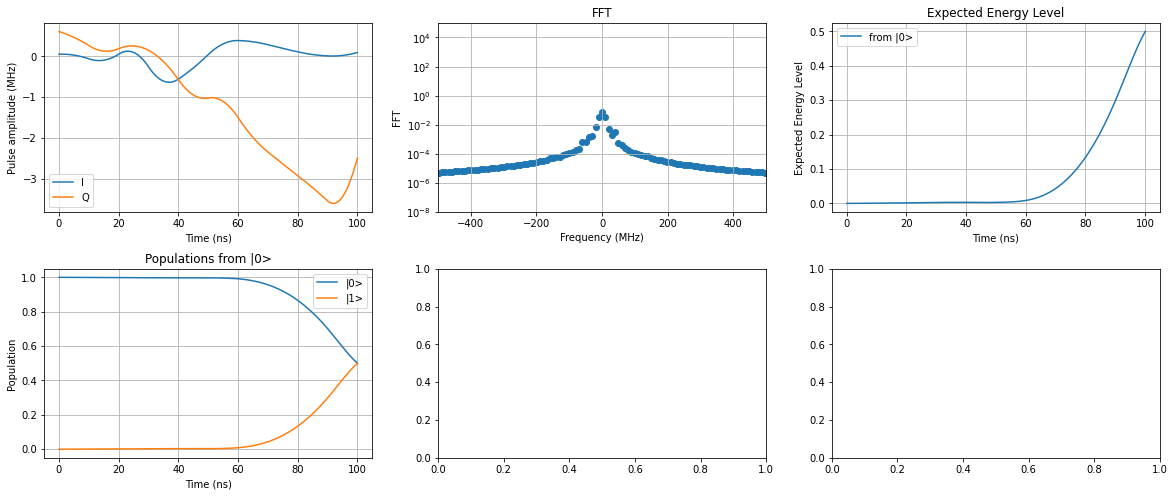

In [12]:
# You can simulate the dynamics under Lindbladian noise operators in Quandary (for decay and dephasing noise).
# To do so, the only thing to change is to pass the decay and dephasing times to the quandary configuration. All other options and runtypes are the same. 
# Note that the Lindblad solver is computationally more expensive, especially for gate optimization. It might be good to pre-optimize on the closed system first and use the optimized parameters as initial guess for the Lindblad solver.
# Here is an example for the state-to-state transfer problem

# State-to-state transfer configuration
Ne = [2]    # Number of essential states
Ng = [0]    # Number of guard levels 
targetstate =  [1.0/np.sqrt(2), 1.0/np.sqrt(2)]   # target state
initialcondition = "pure, 0"   # initial ground state
T = 100.0                      # pulse length
tol_infidelity = 1e-5          # Infidelity tolerance
maxiter = 50                   # Maximum number of iterations

T1 = [100000.0]  # T1 decay time
T2 = [80000.0]   # T2 dephasing time
myconfig_lblad = QuandaryConfig(Ne=Ne, Ng=Ng, T=T, targetstate=targetstate, initialcondition=initialcondition, T1=T1, T2=T2, maxiter=maxiter)


# # Pre-optimize on the closed-system solver:
# myconfig_closed = QuandaryConfig(Ne=Ne, Ng=Ng, T=T, targetstate=targetstate, initialcondition=initialcondition)
# t, pt, qt, infidelity, expectedEnergy, population = quandary_run(myconfig_closed, ncores=1, quandary_exec=quandary_exec) 
# print(f"\nOptimized Fidelity = {1.0 - infidelity}")

# # Evaluate the optimized pulses using the open system solver (runtype="simulate"):
# myconfig_lblad.pcof0 = myconfig_closed.popt
# t, pt, qt, infidelity, expectedEnergy, population = quandary_run(myconfig_lblad, ncores=1, runtype="simulation", quandary_exec=quandary_exec) 
# print(f"\nFidelity under noise = {1.0 - infidelity}")

# # Pass the cosed-system optimized parameters to the initial guess of the lindblad solver 
# myconfig_lblad.pcof0 = myconfig_closed.popt

# Optimize on the lindblad solver
t, pt, qt, infidelity, expectedEnergy, population = quandary_run(myconfig_lblad, ncores=1, runtype="optimization", quandary_exec=quandary_exec) 
print(f"\nRe-optimized Fidelity under noise = {1.0 - infidelity}")

# # Plot the control pulse and expected energy level evolution.
plot_results_1osc(myconfig_lblad, pt[0], qt[0], expectedEnergy[0], population[0])

In [26]:
# ## COMING SOON: FAQ

# * What to do if the optimizer does not converge?
#     - Run again with a different initial guess (rand_seed, randomize_ctrl_init, initctrl_MHz)
#     - Remove or increase the control bounds (maxctrl_MHz)
#     - Increase the time domain (T)
#     - Increase the number of Bspline basis functions (increase nsplines, or decrease dtau)
#     - Inspect the files written to './run_dir/' (or the user-defined alternative output directory). In particular config.cfg, targetgate/state.dat.

# * What to do if the results don't match to other software, or to my expectations?
#     - Turn on 'verbose=True' and check screen output of quandary_run using the runtype="simulation" mode. Anything suspicious?
#     - Test if the time-step size is small enough (aka if "Pmin" is large enough):
#       Compare the outcome (uT or fidelity) of various "simulation" runs, for increasing numbers of time-steps (increasing "Pmin"). The fidelity amongst those runs should not vary much. If it does, the time-step size should be decreased (by using a larger "Pmin")
#     - Check if the correct pulses are used (e.g. by plotting the returned p and q after "simulation" runs as well as after calling 'evalControl(..)')

# Any time: Please reach out to guenther5@llnl.gov if you have any questions, concerns, or if you found a bug.  